In [47]:
import pickle
import pandas as pd
import numpy as np
import category_encoders as ce

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import matplotlib.pyplot as plt
import seaborn as sns


In [48]:
# подгрузим константы

with open('../libs/data/const_dict.pkl', 'rb') as pkl_file:
    const_dict = pickle.load(pkl_file)

In [49]:
# Производим десериализацию и извлекаем модель из файла формата pkl
with open('data/df_clean.pkl', 'rb') as pkl_file:
    df = pickle.load(pkl_file)

df.head()

,propertyType,baths,fireplace,city,sqft,zipcode,beds,state,PrivatePool,target,...,Heating,Cooling,Elementary,Middle,High,Other,Rating,Distance,interval_year,price/sqft
360897,land,4.0,0,El Paso,10190.0,79922,4.0,TX,0,140000.0,...,0,0,1.0,1.0,1.0,0.0,5.333333,1.51,>=2010,14.0
175476,single,2.5,0,Hixson,1828.0,37343,3.5,TN,0,144500.0,...,1,1,1.0,1.0,1.0,0.0,4.000000,2.20,(1960 - 1969),79.0
351468,single,2.0,0,ORLANDO,1264.0,32803,3.0,FL,0,295000.0,...,1,1,1.0,0.0,2.0,4.0,4.000000,1.50,(1950 - 1959),233.0
48448,land,2.0,0,Statesville,0.0,28625,3.0,NC,0,78500.0,...,0,0,3.0,1.0,1.0,2.0,2.285714,4.70,(1980 - 1989),127.0
108170,single,1.0,1,Charlotte,1016.0,28269,2.0,NC,0,145000.0,...,1,1,1.0,1.0,1.0,0.0,4.000000,2.30,(1940 - 1949),143.0


#### Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3ех сигм)

Целевая метрика 'target':

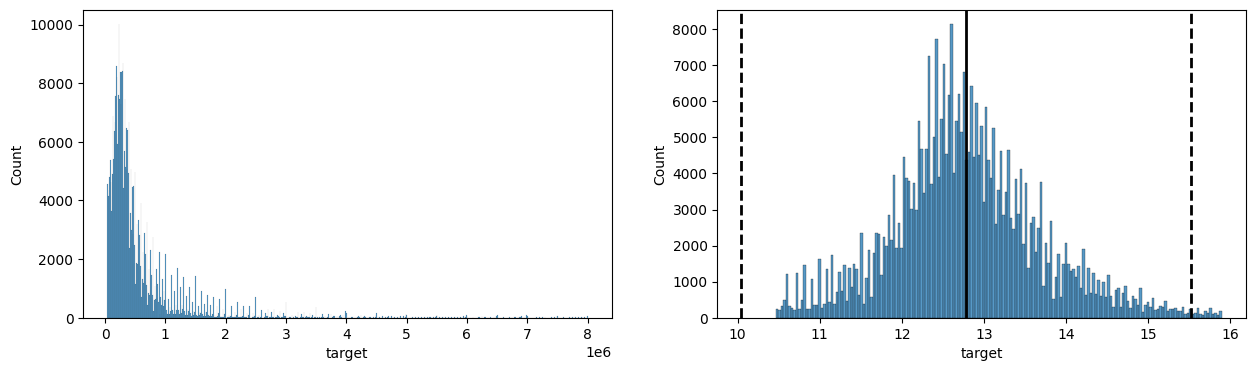

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df, x='target', ax=axes[0]);
#Логарифмируем
log_price = np.log(df['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Параметр 'sqft':

c:\Users\CorhariS\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


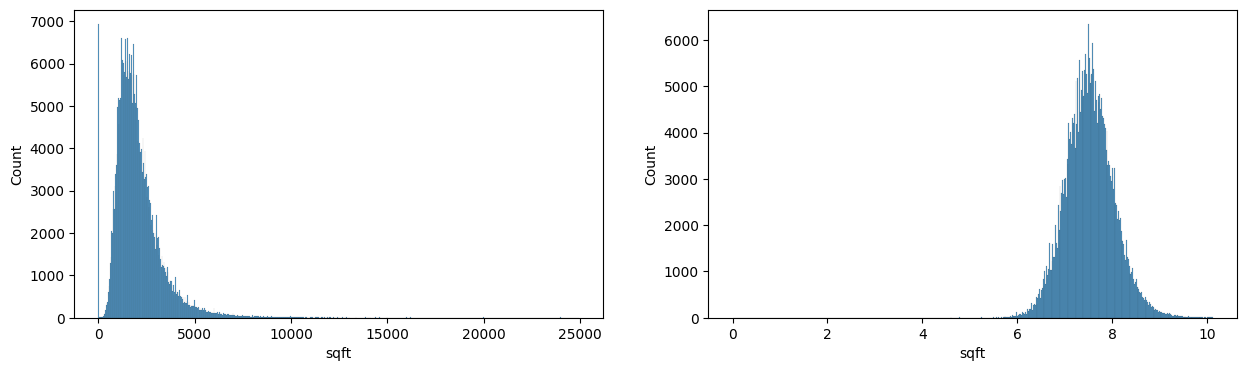

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df, x='sqft', ax=axes[0]);
#Логарифмируем
log_price = np.log(df['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price.mean(), color='k', lw=2)
axes[1].axvline(log_price.mean()+ 3 *log_price.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price.mean()- 3 *log_price.std(),
                color='k', ls='--', lw=2);

Параметр 'price/sqft':

c:\Users\CorhariS\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


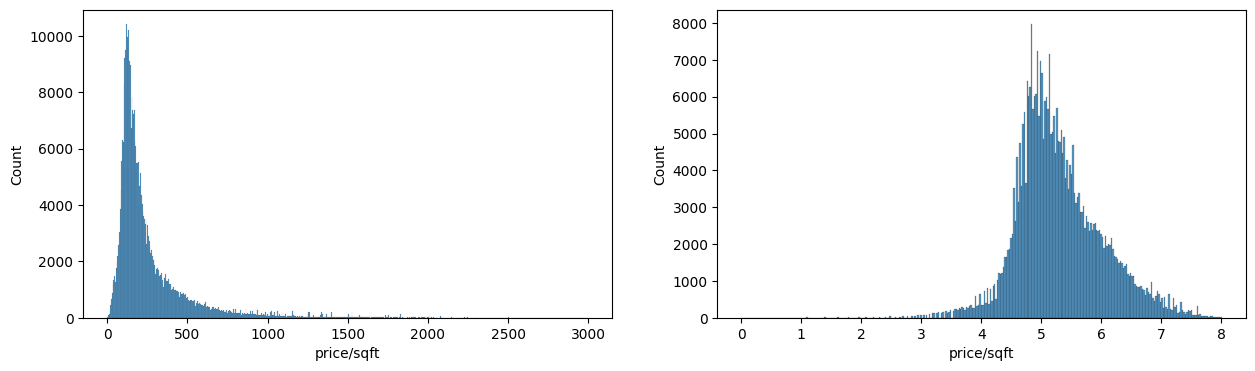

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df, x='price/sqft', ax=axes[0]);
#Логарифмируем
log_price_sqft = np.log(df['price/sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_price_sqft, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_price_sqft.mean(), color='k', lw=2)
axes[1].axvline(log_price_sqft.mean()+ 3 *log_price_sqft.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_price_sqft.mean()- 3 *log_price_sqft.std(),
                color='k', ls='--', lw=2);

In [53]:
temp_data = df.copy()

#### Избавимся от выбросов с помощью метода z-отклонений на логарифмированных признаках.  ####

In [54]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, const_dict, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    
    # Пишем в справочник констант значение lower_bound и upper_bound
    feature_lower_bound = feature+'_lower_bound'
    feature_upper_bound = feature+'_upper_bound'
    const_dict[feature_lower_bound] = lower_bound
    const_dict[feature_upper_bound] = upper_bound
    
    return outliers, cleaned
#Производим очистку 
outliers, temp_cleaned = outliers_z_score(temp_data, 'target', const_dict, log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft', const_dict, log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'price/sqft', const_dict, log_scale=True)

print('Shape before cleaning outliers: {}'.format(temp_data.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (350353, 22)
Shape after cleaning outliers: (339138, 22)


#### Проведем кодирование признаков

In [55]:
# кодирование поля zipcode (BinaryEncoder)
bin_encoder = ce.BinaryEncoder(cols=['zipcode'])
s_zipcode = temp_cleaned['zipcode']
zipcode_bin = bin_encoder.fit_transform(s_zipcode)
temp_cleaned = pd.concat([temp_cleaned, zipcode_bin], axis=1)

# кодирование поля city (BinaryEncoder)
bin_encoder = ce.BinaryEncoder(cols=['city'])
s_city = temp_cleaned['city'] 
city_bin = bin_encoder.fit_transform(s_city)
temp_cleaned = pd.concat([temp_cleaned, city_bin], axis=1)

# кодирование поля state (BinaryEncoder)
bin_encoder = ce.BinaryEncoder(cols=['state'])
s_state = temp_cleaned['state']
state_bin = bin_encoder.fit_transform(s_state)
temp_cleaned = pd.concat([temp_cleaned, state_bin], axis=1)

# кодирование поля propertyType
s_propertyType = temp_cleaned['propertyType']
temp_cleaned = pd.get_dummies(temp_cleaned, columns=['propertyType']) 

# кодирование поля interval_year
s_interval_year = temp_cleaned['interval_year']
temp_cleaned = pd.get_dummies(temp_cleaned, columns=['interval_year'])

Создадим справочник закодированных признаков dict_binary. Данный справочник будет иметь следующую структуру:
~~~
{'название признака 1': {'Бинарные имена признака': ['Имя_1','Имя_1', ...]
                         'значение1 признака': [0, 0, ...] 
                         'значение2 признака': [0, 0, ...]
                         ...
                         'значениеN признака': [0, 0, ...]
                        } 

'название признака 2': {'Бинарные имена признака': ['Имя_1','Имя_1', ...]
                         'значение1 признака': [0, 0, ...] 
                         'значение2 признака': [0, 0, ...]
                         ...
                         'значениеN признака': [0, 0, ...]
                        }   
...                     

}
~~~

In [56]:
dict_binary=dict()

def fill_dict_binary(df_bin):
    dict_bin = dict()
    lst_cols_bin = df_bin.columns.to_list()
    dict_bin['col_names'] = lst_cols_bin[1:]

    for i, row in df_bin.iterrows():
        dict_bin[row[lst_cols_bin[0]]] = [row[x] for x in lst_cols_bin[1:]]
        
    return dict_bin

Заполняем справочник dict_binary. keys: 'zipcode', 'city', 'state', 'propertyType', 'interval_year' 

In [57]:
# zipcode
df_zipcode = pd.concat([s_zipcode, zipcode_bin], axis=1)
df_zipcode = df_zipcode.drop_duplicates()
dict_binary['zipcode'] = fill_dict_binary(df_zipcode)
const_dict['zipcode_mode'] = s_zipcode.mode()[0] 

# city
df_city = pd.concat([s_city, city_bin], axis=1)
df_city = df_city.drop_duplicates()
dict_binary['city'] = fill_dict_binary(df_city)
const_dict['city_mode'] = s_city.mode()[0] 

# state
df_state = pd.concat([s_state, state_bin], axis=1)
df_state = df_state.drop_duplicates()
dict_binary['state'] = fill_dict_binary(df_state)
const_dict['state_mode'] = s_state.mode()[0] 

lst_columns = temp_cleaned.columns.to_list()
# propertyType
lst_propertyType = list(filter(lambda x: 'propertyType' in x, lst_columns))
df_propertyType = pd.concat([s_propertyType, temp_cleaned[lst_propertyType]], axis=1)
df_propertyType = df_propertyType.drop_duplicates()
dict_binary['propertyType'] = fill_dict_binary(df_propertyType)
const_dict['propertyType_mode'] = s_propertyType.mode()[0] 

# interval_year
lst_interval_year = list(filter(lambda x: 'interval_year' in x, lst_columns))
df_interval_year = pd.concat([s_interval_year, temp_cleaned[lst_interval_year]], axis=1)
df_interval_year = df_interval_year.drop_duplicates()
dict_binary['interval_year'] = fill_dict_binary(df_interval_year)
const_dict['interval_year_mode'] = s_interval_year.mode()[0] 

Проведем нормализацию следующих признаков:
* 'baths',
* 'sqft',
* 'beds', 
* 'Elementary', 
* 'Middle', 
* 'High',
* 'Other',
* 'Rating', 
* 'Distance',
* 'price/sqft'


In [58]:
temp_cleaned['beds'].describe()

count    339138.000000
mean          3.285257
std           2.911950
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         871.000000
Name: beds, dtype: float64

In [59]:
data_scaled = temp_cleaned.copy()

col_scale = ['baths', 'sqft', 'beds', 'Elementary', 'Middle', 'High', 'Other', 'Rating', 'Distance', 'price/sqft']
scaler = MinMaxScaler()
 
data_scaled[col_scale] = scaler.fit_transform(data_scaled[col_scale].values)

# Запишим в справочник констант модель MinMaxScaler c обучающими параметрами
const_dict['MinMaxScaler_model'] = scaler

data_scaled.head()

,baths,fireplace,city,sqft,zipcode,beds,state,PrivatePool,target,Remodeled year,...,interval_year_(1930 - 1939),interval_year_(1940 - 1949),interval_year_(1950 - 1959),interval_year_(1960 - 1969),interval_year_(1970 - 1979),interval_year_(1980 - 1989),interval_year_(1990 - 1999),interval_year_(2000 - 2009),interval_year_<1850,interval_year_>=2010
175476,0.003333,0,Hixson,0.071506,37343,0.004018,TN,0,144500.0,1,...,0,0,0,1,0,0,0,0,0,0
351468,0.002667,0,ORLANDO,0.048849,32803,0.003444,FL,0,295000.0,1,...,0,0,1,0,0,0,0,0,0,0
108170,0.001333,1,Charlotte,0.038886,28269,0.002296,NC,0,145000.0,1,...,0,1,0,0,0,0,0,0,0,0
214823,0.002667,1,Oxnard,0.047604,93033,0.004592,CA,0,515000.0,0,...,0,0,1,0,0,0,0,0,0,0
151884,0.004667,0,Richmond,0.135781,77406,0.004592,TX,0,421990.0,0,...,0,0,0,0,0,1,0,0,0,0


In [60]:
# Удалим лишнии колонки
data_scaled = data_scaled.drop(columns=['zipcode', 'city', 'state'], axis=1)

### Моделирование + Оценка модели

Заранее создадим функцию, которая будет расчитывать метрики:

1. MAE - средняя абсолютная ошибка (целевая метрика)
2. MAPE - средняя абсолютная ошибка в процентах 
3. $R^2$ - коэффициент детерминации 

In [15]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

Разделяем всю выборку на тренировочную и тестовую в соотношении 80/20.

На тренировочной выборке будем обучать модели, а на тестовой проверять их качество. 

In [16]:
y = data_scaled['target']
x = data_scaled.drop(columns='target')

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

#Запишим в справочник констант порядок колонок в X_train, необходимый для сервиса предсказания
const_dict['order_columns_name'] = X_train.columns.to_list()

#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (271310, 84)
Test shape: (67828, 84)


**Модель линейной регрессии:**

In [17]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)
 
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.714
Train MAE: 159573.138
Train MAPE: 48.391


Test R^2: 0.711
Test MAE: 158161.302
Test MAPE: 48.257


**Модель случайного леса:**

In [323]:

model_rfr = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

model_rfr.fit(X_train, y_train)

y_train_pred = model_rfr.predict(X_train)
y_test_pred = model_rfr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.839
Train MAE: 110640.574
Train MAPE: 33.601


Test R^2: 0.851
Test MAE: 109634.490
Test MAPE: 32.104


Улучшим модель при помощи подбора оптимальных парамметров

In [305]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 10, 20, 1)
    }

# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth'])
             }
  
    # используем эту комбинацию для построения модели
    model = RandomForestRegressor(**params, random_state=random_state, n_jobs=-1)

    # обучаем модель
    model.fit(X, y)
    score = metrics.mean_absolute_percentage_error(y, model.predict(X))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return score


In [306]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=10, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))


100%|██████████| 10/10 [37:08<00:00, 222.82s/trial, best loss: 0.07683227471146652]
Наилучшие значения гиперпараметров {'max_depth': 20.0, 'n_estimators': 170.0}
CPU times: total: 2h 4min 49s
Wall time: 37min 8s


Лучшие параметры {'n_estimators': 170, 'max_depth': 20}. Обучим нашу модель с этими параметрами

In [307]:
model_rfr = RandomForestRegressor(
    n_estimators=170,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

model_rfr.fit(X_train, y_train)

y_train_pred = model_rfr.predict(X_train)
y_test_pred = model_rfr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.963
Train MAE: 24117.938
Train MAPE: 7.683


Test R^2: 0.900
Test MAE: 41654.694
Test MAPE: 13.158


**Модель AdaBoostRegressor:**

In [18]:
model_abr = AdaBoostRegressor(
    DecisionTreeRegressor(
        min_samples_leaf=4,
        max_depth=15,
        random_state=42
    ),
    random_state=42,
    learning_rate=0.0001,
    n_estimators=100
)

model_abr.fit(X_train, y_train)

y_train_pred = model_abr.predict(X_train)
y_test_pred = model_abr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.929
Train MAE: 32812.690
Train MAPE: 10.386


Test R^2: 0.894
Test MAE: 38730.973
Test MAPE: 11.858


**Модель GradientBoostingRegressor:**

In [ ]:
model_gbr = GradientBoostingRegressor(
    learning_rate=0.5,
    max_depth=5,
    n_estimators=200,
    random_state=42 
)
model_gbr.fit(X_train, y_train)

y_train_pred = model_gbr.predict(X_train)
y_test_pred = model_gbr.predict(X_test)

#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.924
Train MAE: 50500.850
Train MAPE: 16.821


Test R^2: 0.888
Test MAE: 56925.926
Test MAPE: 18.485


**Наилучшие результаты показала модель AdaBoostRegressor, ее и будем использовать для создания сервиса по предсказанию целевой метрики 'target'**

In [19]:
# Производим сериализацию и записываем model_abr в файл формата pkl
with open('../libs/data/model_abr.pkl', 'wb') as output:
    pickle.dump(model_abr, output)

In [345]:
# Производим сериализацию и записываем model_rfr в файл формата pkl
with open('../libs/data/model_rfr.pkl', 'wb') as output:
    pickle.dump(model_rfr, output)

In [61]:
# Производим сериализацию и записываем const_dict в файл формата pkl
with open('../libs/data/const_dict.pkl', 'wb') as output:
    pickle.dump(const_dict, output)

In [62]:
# Производим сериализацию и записываем dict_binary в файл формата pkl
with open('../libs/data/dict_binary.pkl', 'wb') as output:
    pickle.dump(dict_binary, output)